In [1]:
# Import Libraries
import pandas as pd
import gensim
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import time
from IPython.display import clear_output
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.manifold import TSNE

In [2]:
#Import Raw Data and Visualize it
raw_alerts = pd.read_csv(r'event_dump.csv')
raw_alerts.head().transpose()

,0,1,2,3,4
Source,AUPRDGLB-HRAPP03,USPRDEMPRECWEB03,USDEVGLB-HRAPP02,UKDEVPAYROLDBA01,dummy.au-x6.global.com
AlertTime,6/2/2021 03:56:35,6/2/2021 05:55:32,6/2/2021 07:50:34,6/2/2021 07:50:48,6/2/2021 10:49:54
AlertDescription,Memory Utilization is 74% in Warning State on...,Memory Utilization is 70% in Warning State on...,CPU Utilization is 95% in Critical State on U...,CPU Utilization is 93% in Critical State on U...,Interface Utilization is 75% in Warning State...
AlertClass,OperatingSystem,OperatingSystem,OperatingSystem,OperatingSystem,network performance
AlertType,Server,Server,Server,Server,network
AlertManager,PlatformMonitoring-Tool,PlatformMonitoring-Tool,PlatformMonitoring-Tool,PlatformMonitoring-Tool,network-monitoring-tool


In [3]:
raw_alerts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Source            1051 non-null   object
 1   AlertTime         1051 non-null   object
 2   AlertDescription  1051 non-null   object
 3   AlertClass        1051 non-null   object
 4   AlertType         1051 non-null   object
 5   AlertManager      1051 non-null   object
dtypes: object(6)
memory usage: 49.4+ KB


In [4]:
raw_alerts['AlertClass'].unique() 

array(['OperatingSystem', 'network performance', 'Transaction Monitoring',
       'network availability', 'MERAKI', 'configuration'], dtype=object)

In [5]:
raw_alerts['AlertType'].unique()

array(['Server', 'network ', 'APPLICATION', 'settingsChanged'],
      dtype=object)

In [6]:
#Perform Pre-Processing for NLP
nltk.download('wordnet')
nltk.download('words')
words = set(nltk.corpus.words.words())
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
                        
def preprocess(text):
    result = []
    words = set(nltk.corpus.words.words())
    domain_terms = set(["cpu","interface","application","failure",
                        "https","outage", "synthetic","timeout","utc",
                        "www","simulation","simulated","http",
                        "response","app","network","emprecord",
                        "global_hr","pyroll","employee_lms","demoapp1",
                        "emp_logistics_summary","demo","down", "tcp" ,
                        "connect","emp_tsms","payroll_sap_gts",
                        "demoapp3","high","state"])
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            if token.lower() in words or token.lower() in domain_terms:
                result.append(lemmatize_stemming(token))
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gauravbhardwaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/gauravbhardwaj/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
event_msg = np.array(raw_alerts[['AlertDescription']])
temp = []
for i in event_msg :
    temp.append(i[0])
event_msg = temp

for i,v in enumerate(event_msg):
    event_msg[i] = preprocess(v)

for i,v in enumerate(event_msg):
    event_msg[i] = " ".join(v)

In [8]:
#Perform Vectorization 
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 10000)
tf_idf = tf_idf_vectorizor.fit_transform(event_msg)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

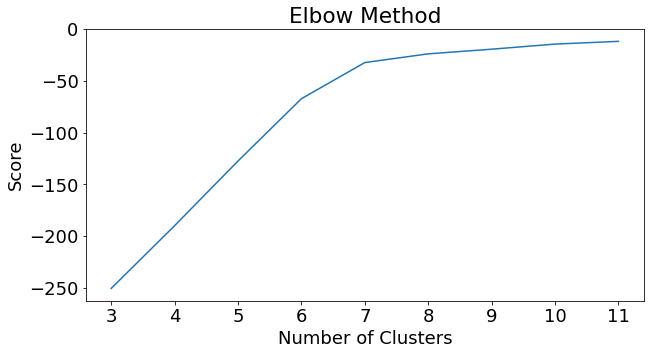

In [9]:
#Using Elbow method determine how many clusters are possible
number_clusters = range(3, 12)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(tf_idf_array).score(tf_idf_array) for i in range(len(kmeans))]
score
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [10]:
# Create Clusters using K-Means algorithm
df_temp = raw_alerts
no_cluster = 7
kmeans = KMeans(n_clusters=no_cluster, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(tf_idf_array)
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
labels = {}
terms = tf_idf_vectorizor.get_feature_names()
for i in range(no_cluster):
    print("Cluster %d:" % i),
    labels[i]=terms[order_centroids[i, 0]]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])


Top terms per cluster:
Cluster 0:
 interfac
 warn
 state
 util
 session
 client
 transact
 label
 dashboard
 synthet
Cluster 1:
 cpu
 critic
 state
 util
 interfac
 warn
 global_hr
 payroll_sap_gt
 app
 demo
Cluster 2:
 global_hr
 warn
 memori
 util
 state
 critic
 pyrol
 client
 session
 transact
Cluster 3:
 pyrol
 warn
 memori
 util
 state
 critic
 client
 session
 transact
 global
Cluster 4:
 emprecord
 warn
 memori
 state
 util
 critic
 client
 session
 transact
 azur
Cluster 5:
 memori
 critic
 util
 state
 warn
 emprecord
 pyrol
 client
 session
 transact
Cluster 6:
 simul
 session
 client
 page
 transact
 affect
 web
 payroll_sap_gt
 applic
 app


In [11]:
print("Cluster Labels are: \n", labels)

Cluster Labels are: 
 {0: 'interfac', 1: 'cpu', 2: 'global_hr', 3: 'pyrol', 4: 'emprecord', 5: 'memori', 6: 'simul'}


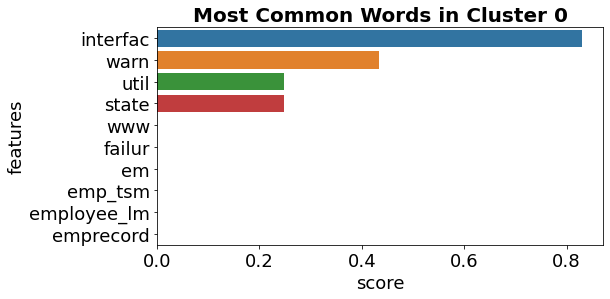

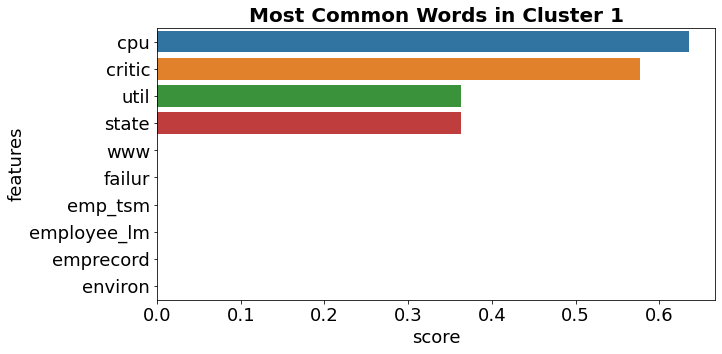

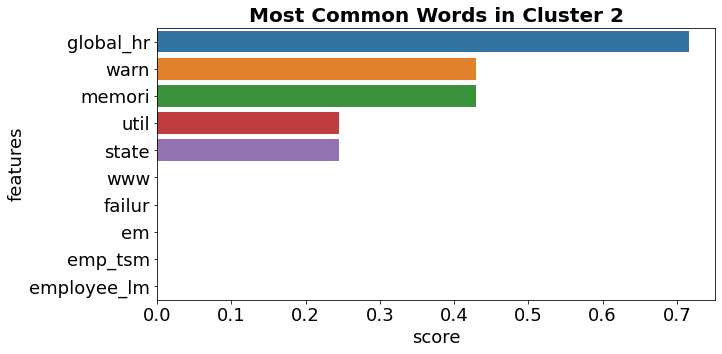

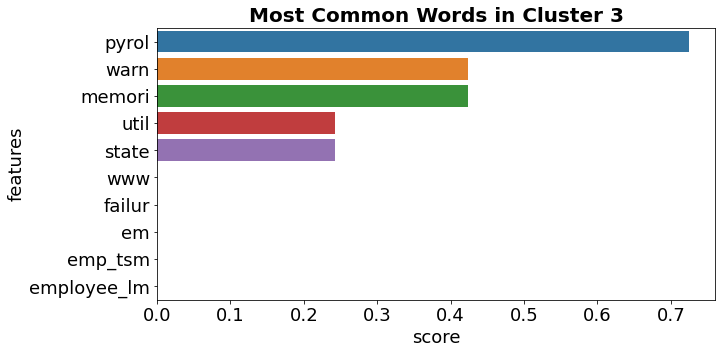

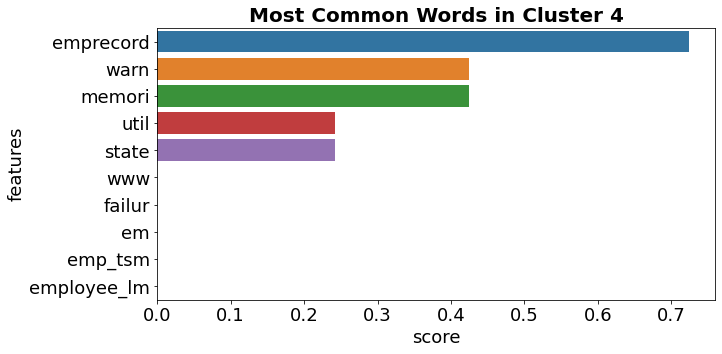

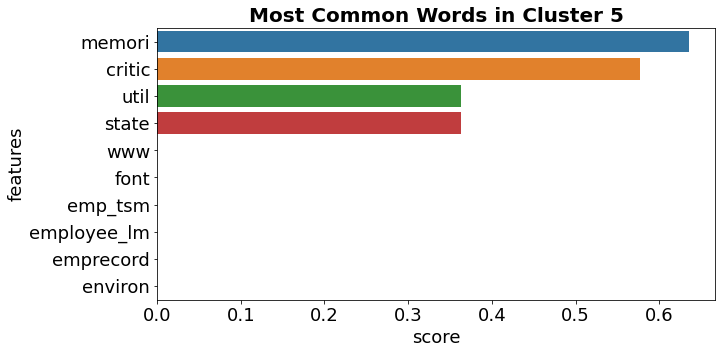

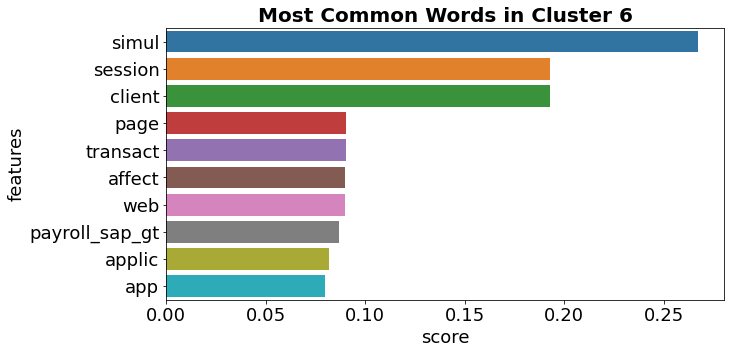

In [12]:
preds = kmeans.predict(tf_idf_array)
df_temp['cluster'] = preds
df_temp['AlertTime'] = pd.to_datetime(df_temp['AlertTime'])
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) 
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) 
        sorted_means = np.argsort(x_means)[::-1][:n_feats] 
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), \
                  fontsize=20, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , \
                    data = dfs[i][:n_feats])
        plt.show()
        
n_feats = 20
dfs = get_top_features_cluster(tf_idf_array, preds, n_feats)
plotWords(dfs, 10)
        


<AxesSubplot:xlabel='AlertTime', ylabel='Cluster Number'>

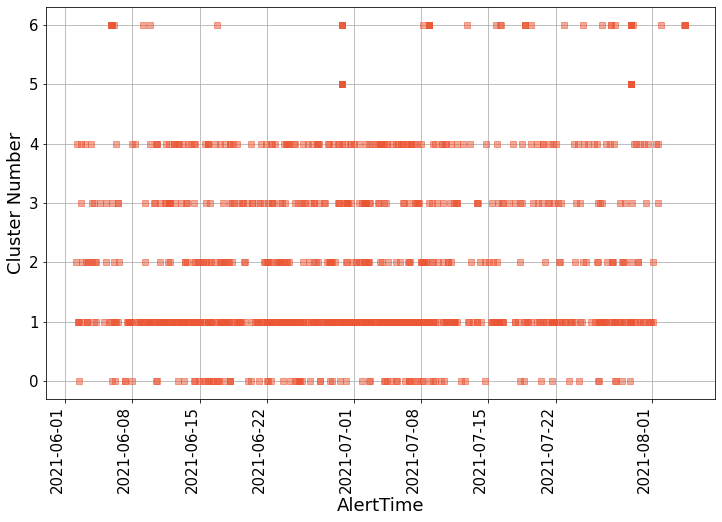

In [18]:
#Analyze clusters on time scale 
df_temp.plot(x='AlertTime', y='cluster', lw=0, marker='s', color ="#eb5634",\
    figsize=(12,8),rot = 90,  alpha = 0.5,fontsize = 15,grid=True, legend=False,\
             ylabel="Cluster Number")


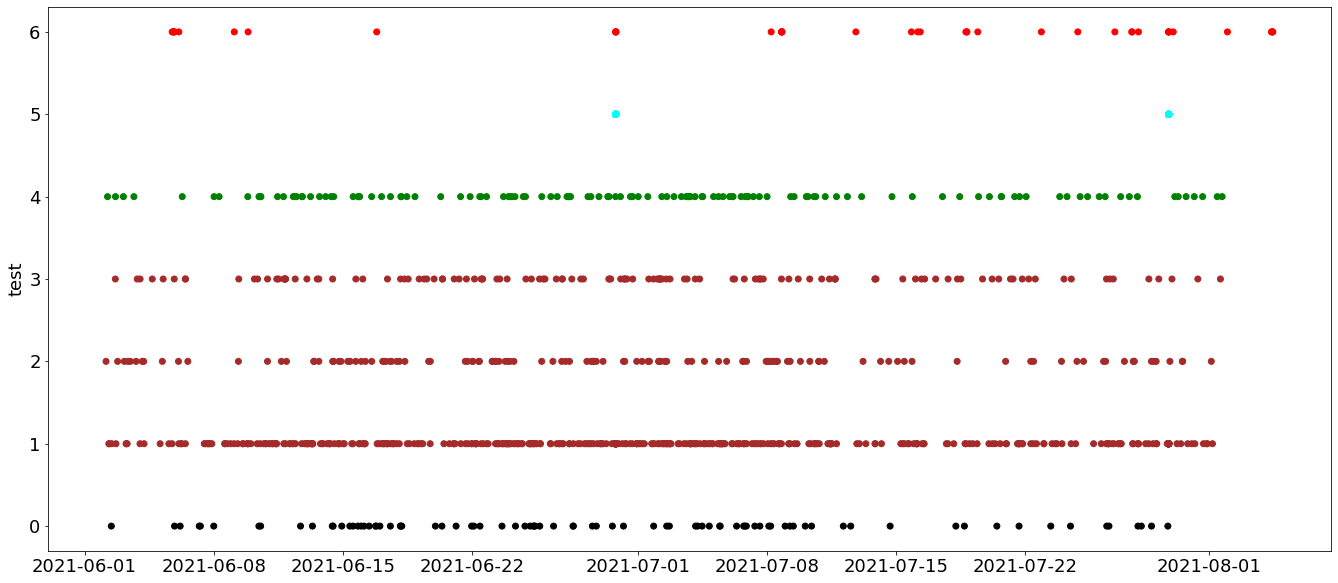

In [19]:
df_temp[['cluster','AlertTime']]
cols = ["black" ,"brown", "brown", "brown", "green","cyan","red"]
df_temp["color"] = [cols[int(i)] for i in df_temp['cluster']]
plt.figure(figsize=(23,10))
plt.scatter(df_temp["AlertTime"], df_temp["cluster"], c=df_temp["color"])
plt.ylabel("test")
plt.show()

In [25]:
# Cluster 6 contains keywords indicating an outage. 
# Let's give a name to cluster 6 and analyze its alerts
pd.set_option('display.max_colwidth', None)
df_appcluster=df_temp[df_temp['cluster'] == 6 ]
df_appcluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 31 to 1050
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Source            43 non-null     object        
 1   AlertTime         43 non-null     datetime64[ns]
 2   AlertDescription  43 non-null     object        
 3   AlertClass        43 non-null     object        
 4   AlertType         43 non-null     object        
 5   AlertManager      43 non-null     object        
 6   cluster           43 non-null     int32         
 7   color             43 non-null     object        
dtypes: datetime64[ns](1), int32(1), object(6)
memory usage: 2.9+ KB


In [26]:
df_appcluster[['AlertTime','AlertClass','AlertType','AlertDescription']]

,AlertTime,AlertClass,AlertType,AlertDescription
31,2021-06-05 18:03:29,Transaction Monitoring,APPLICATION,"APPLICATION: EMPRecord global outage:<h3>OPEN Problem P-210796 in environment </h3><br><small>Problem detected at: 22:59 (UTC) 05.06.2021</small><hr><b>1 impacted application</b><hr><br><div><span>Synthetic monitor</span><br><b><span style=""color:#dc172a; font-size:120%"">DNN - DummyOrg</span></b><br><p style=""margin-left:1em""><b><span style=""font-size:110%"">Synthetic monitor global outage</span></b><br>1 failure<br>Actions: Loading of ""https://www.dummyorg.com""<br>Type: Wait for page complete timeout<br>Geolocation: N. Carolina</p></div><hr><p>"
32,2021-06-05 19:15:03,Transaction Monitoring,APPLICATION,Synthetic monitoring failed for Client Session Simulation EMPRecord_DQ
33,2021-06-05 19:15:18,Transaction Monitoring,APPLICATION,Simulated transaction Check_HTTP_Service failed for Client Session Simulation EMPRecord_DQ
34,2021-06-05 20:24:52,Transaction Monitoring,APPLICATION,HTTP access is slow for web page EMP_Logistics_Summary. This is affecting Client Session Simulation Global_HR
37,2021-06-05 21:08:29,Transaction Monitoring,APPLICATION,Server response time is high for web page Employee_LMS. This is affecting Client Session Simulation Payroll_SAP_GTS
40,2021-06-06 02:42:29,Transaction Monitoring,APPLICATION,Process DEMOAPP1_Process for Application DEMO APP is down
66,2021-06-09 02:51:24,network availability,network,The current status of Interface Adaptive Security Appliance 'Ethernet0/0' interface - Ethernet0/0 on the node dummy.uk-x1.global.com with IP Address 172.28.176.190 is Down.
75,2021-06-09 20:51:24,Transaction Monitoring,APPLICATION,HTTP access is slow for web page EMP_Logistics_Summary. This is affecting Client Session Simulation Global_HR
198,2021-06-16 20:17:09,Transaction Monitoring,APPLICATION,Service DEMOAPP1_Service for Application DEMO APP is down.
510,2021-06-29 19:31:41,Transaction Monitoring,APPLICATION,TCP connect time is high when accessing web page EMP_TSMS. This is affecting Client Session Simulation Payroll_SAP_GTS
